# Reconocimiento de digitos


In [2]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=96d855c61de4ceba4c59c49face66604320b095f8a4d4fc8768db76d58bbed19
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# Imports

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import pickle
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras, optimizers
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import layers
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.15.0


In [3]:
# Hiper parametros
LR = 1e-3
EPOCHS = 2
BATCH_SIZE = 64
CONV_DIM1 = 56
CONV_DIM2 = 100

Establecer la semilla aleatoria para la reproducibilidad y ignorar los mensajes de advertencia

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

plt.rc('figure', autolayout=True)
plt.rc('axes', titleweight='bold',
        titlesize=15)

plt.rc('font', size=12)

Descargar la data

In [5]:
import zipfile
import wget
import os


data_path = os.getcwd()


train_link = 'https://github.com/kubeflow/examples/blob/master/digit-recognition-kaggle-competition/data/train.csv.zip?raw=true'


wget.download(train_link, f'{data_path}/data_csv.zip')



with zipfile.ZipFile(f"{data_path}/data_csv.zip","r") as zip_ref:
    zip_ref.extractall(data_path)


# Cargar y preprocesar la data

## Cargar data

In [6]:
data_path = os.getcwd()
train_data_path = data_path + '/train.csv'
train_df = pd.read_csv(train_data_path)

Ahora vamos a explorar los datos. Para ello, utilizaremos el método `head` de pandas para visualizar las primeras cinco filas de nuestro conjunto de datos.

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Ejemplo de data

Se usa una funcion para previsualizar algunas valores del dataset

Este numero es el 1


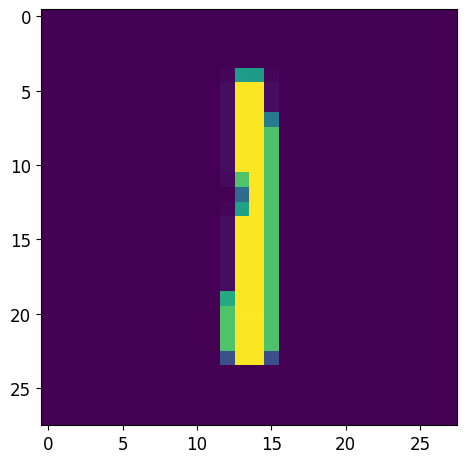

In [9]:
def crear_imagen(datos):
  # Convertir los datos en un array de NumPy
  imagen = np.array(datos)

  # Dar forma al array como una imagen de 28x28
  imagen = imagen.reshape((28, 28))

  # Devolver la imagen
  return imagen

dato=2
# Crear una imagen utilizando las columnas de la 1 a la última
imagen = crear_imagen(train_df.iloc[dato, 1:])
numero = f"Este numero es el {train_df.iloc[dato, 0]}"
print(numero)
# Mostrar la imagen
import matplotlib.pyplot as plt
plt.imshow(imagen)

# Dimensiones de la data

In [10]:
train_df.shape

(42000, 785)

In [12]:
ntrain = train_df.shape[0]


all_data = train_df
print("all_data size is : {}".format(all_data.shape))

all_data size is : (42000, 785)


## Preprocesar la data

In [13]:
all_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
all_data_X = all_data.drop('label', axis=1)
all_data_y = all_data.label

In [15]:
all_data_X = all_data_X.values.reshape(-1,28,28,1)
all_data_X = all_data_X / 255.0

In [16]:
X = all_data_X[:ntrain].copy()
y = all_data_y[:ntrain].copy()

In [17]:
# Dividir el dataset train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [30]:
# Dividir el dataset train y validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

# Definir y entrenar el modelo

In [19]:
def build_model(hidden_dim1=int(CONV_DIM1), hidden_dim2=int(CONV_DIM2), DROPOUT=0.5):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = hidden_dim1, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Conv2D(filters = hidden_dim2, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Conv2D(filters = hidden_dim2, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = "softmax")
    ])

    model.build(input_shape=(None,28,28,1))

    return model

In [20]:
model = build_model()

In [21]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 56)        1456      
                                                                 
 dropout (Dropout)           (None, 28, 28, 56)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 100)       50500     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 100)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 100)       90100     
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 100)       0         
                                                                 
 flatten (Flatten)           (None, 78400)             0

In [22]:
model.compile(optimizers.Adam(learning_rate=float(LR)),
              loss=SparseCategoricalCrossentropy(),
              metrics=SparseCategoricalAccuracy(name='accuracy'))

In [24]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=int(BATCH_SIZE), epochs=int(EPOCHS))

Epoch 1/2
530/530 [==============================] - 10s 8ms/step - loss: 0.2086 - accuracy: 0.9349
Epoch 2/2
530/530 [==============================] - 4s 8ms/step - loss: 0.0738 - accuracy: 0.9775


## Evaluacion del modelo

In [25]:
test_loss, test_acc = model.evaluate(np.array(X_test),  np.array(y_test), verbose=0)
print("Test_loss: {}, Test_accuracy: {} ".format(test_loss,test_acc))

Test_loss: 0.06364840269088745, Test_accuracy: 0.981587290763855 


# Matriz de confusion

In [28]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

132/132 [==============================] - 1s 3ms/step


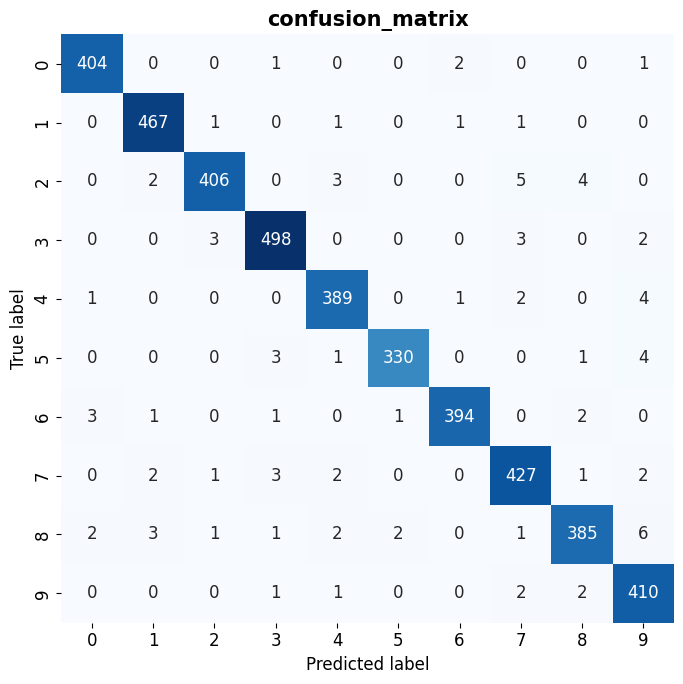

In [29]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='g', cbar=False, annot=True, cmap='Blues')
plt.title('confusion_matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Scoring del modelo

In [28]:
val_loss, val_acc = model.evaluate(np.array(X_val),  np.array(y_val), verbose=0)
print("Test_loss: {}, Test_accuracy: {} ".format(val_loss,val_acc))

Test_loss: 0.07132050395011902, Test_accuracy: 0.978151261806488 
